# Classifying images of COVID-19 for Scheme1-Dataset
Scheme1-Dataset is comprised of three classes i.e.COVID, NORMAL and VIRALPNEUMONIA

In [106]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
#from mlxtend.plotting import plot_confusion_matrix
import copy
from itertools import cycle

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [2]:
print (torch.__version__)
print(torchvision.__version__)

1.9.1
0.10.1


# Set Seaborn style.

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
data_dir ='./ProcessedGANImages-Dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['Covid19', 'Normal', 'ViralPneumonia']


In [4]:
covid19_files = os.listdir(data_dir + "/train/Covid19")
print('No. of training examples for Covid19:', len(covid19_files))
print(covid19_files[:5])

No. of training examples for Covid19: 4000
['Epoch-1521-fake_images4.png', 'Epoch-1522-fake_images1.png', 'Epoch-1522-fake_images4.png', 'Epoch-1522-fake_images5.png', 'Epoch-1523-fake_images0.png']


In [5]:
normal_files = os.listdir(data_dir + "/train/Normal")
print("No. of test examples for Lung Opacity:", len(normal_files))
print(normal_files[:5])

No. of test examples for Lung Opacity: 4000
['Epoch-1023-fake_images4.png', 'Epoch-1023-fake_images5.png', 'Epoch-1024-fake_images0.png', 'Epoch-1024-fake_images1.png', 'Epoch-1024-fake_images2.png']


In [6]:
viral_pneumonia_files = os.listdir(data_dir + "/train/ViralPneumonia")
print("No. of test examples for Viral pneumonia:", len(viral_pneumonia_files))
print(viral_pneumonia_files[:5])

No. of test examples for Viral pneumonia: 4000
['Epoch-1179-fake_images5.png', 'Epoch-1180-fake_images0.png', 'Epoch-1180-fake_images1.png', 'Epoch-1180-fake_images2.png', 'Epoch-1180-fake_images3.png']


# Creating training set

In [12]:
img_size = 100
train_dataset = ImageFolder(data_dir+'/train', transform=tt.Compose
                      ([tt.ToTensor(), 
                        tt.Grayscale(num_output_channels=1), 
                        tt.Resize((100,100)),
                        tt.RandomHorizontalFlip(),
                        #tt.RandomRotation(degrees=(-90, 90)),
                        tt.Pad(8, padding_mode='reflect'),
                        tt.RandomCrop(img_size),
                        #tt.Normalize(mean=(0.5157), std=(0.2546))
                        tt.Normalize(mean=(0.5), std=(0.5))
                       ]
                      ))

# Exploring data set

In [13]:
len(train_dataset)

12000

In [14]:
train_dataset.classes

['Covid19', 'Normal', 'ViralPneumonia']

In [15]:
# The list of classes is stored in the `.classes` property of the dataset. 
#The numeric label for each element corresponds to index of the element's label in the list of classes.
train_dataset.class_to_idx 

{'Covid19': 0, 'Normal': 1, 'ViralPneumonia': 2}

In [ ]:
train_dataset.targets.bincount()

In [ ]:
sample=next(iter(train_dataset))
len(sample)

In [ ]:
image,label=sample
print("Image Shape:",image.shape)
print("Label Shape:",torch.tensor(label).shape)

In [ ]:
image.squeeze().shape

# Calculating mean and std

In [ ]:
#loader_normalized = DataLoader(train_dataset,batch_size=len(train_dataset), num_workers=1)
#data = next(iter(loader_normalized))
#data[0].mean(),data[0].std()

# Shape and Label of random samples

In [16]:
img, label = train_dataset[0]
print(img.shape, label)
img

torch.Size([1, 100, 100]) 0


tensor([[[ 0.6620, -0.2230, -0.6389,  ..., -0.8859, -0.9111, -0.9242],
         [-0.0667, -0.5247, -0.5941,  ..., -0.8706, -0.8775, -0.9184],
         [-0.8566, -0.8200, -0.6577,  ..., -0.8875, -0.8517, -0.8714],
         ...,
         [ 0.7231,  0.6898,  0.6058,  ...,  0.5504,  0.5163,  0.4743],
         [ 0.6913,  0.6926,  0.6347,  ...,  0.5572,  0.5582,  0.4821],
         [ 0.7080,  0.6936,  0.5746,  ...,  0.5825,  0.6656,  0.4893]]])

In [17]:
img, label = train_dataset[1201]
print(img.shape, label)
torch.min(img), torch.max(img)

torch.Size([1, 100, 100]) 0


(tensor(-1.), tensor(0.9861))

# View random samples

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [19]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')

Label:  Covid19 (0)


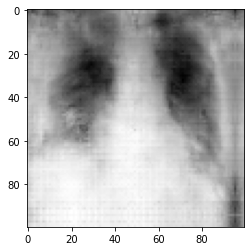

In [20]:
show_example(*train_dataset[100])

Label:  Normal (1)


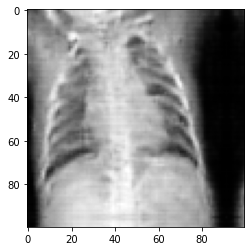

In [21]:
show_example(*train_dataset[4023])

Label:  ViralPneumonia (2)


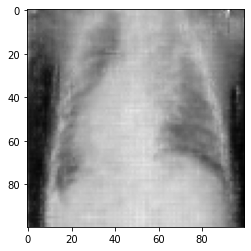

In [22]:
show_example(*train_dataset[8023])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (20 percent) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

# Get Train and Validation Samples

In [23]:
random_seed = 42
torch.manual_seed(random_seed);

In [24]:
val_size = int(0.2*len(train_dataset))
#print(val_size)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(9600, 2400)

We can now create data loaders for training and validation, to load the data in batches

In [25]:
from torch.utils.data.dataloader import DataLoader
batch_size=50

In [26]:
train_dl= DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

# Normalized Images

In [27]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


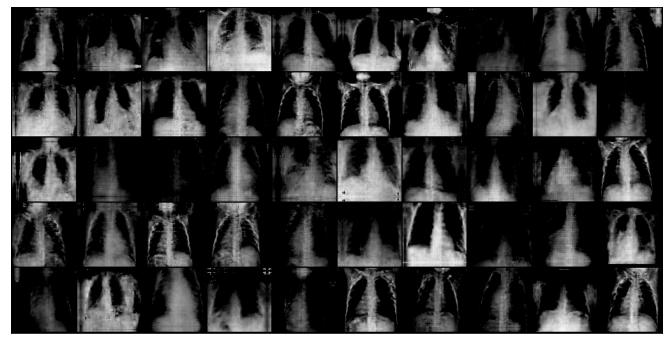

In [28]:
show_batch(train_dl)

# Denormalized Images 

In [29]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 1, 1, 1)
    stds = torch.tensor(stds).reshape(1, 1, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, 0.5,0.5)
        ax.imshow(make_grid(denorm_images[:64], nrow=10).permute(1, 2, 0).clamp(0,1))
        break

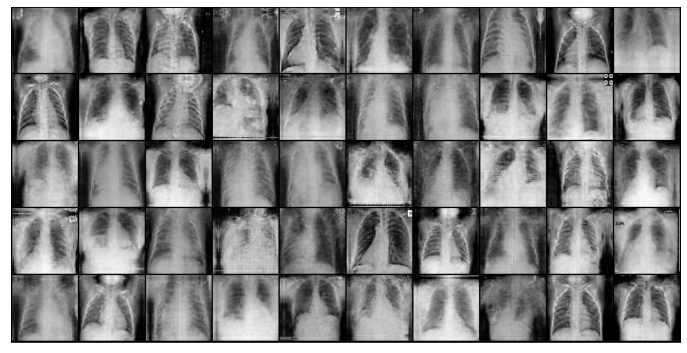

In [30]:
show_batch(train_dl)

# Classes Distribution in dataset

In [ ]:
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train_dataset), plot_title="Entire Dataset (before train/val/test split)")

## Defining the Model (Convolutional Neural Network)



> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(1, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 64, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),# 64 * 50 * 50
            nn.BatchNorm2d(64),# 64 * 50 * 50
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),# 256 * 25 * 25
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512), # 512 * 12 * 12
     nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(1024), # 1024 * 6 * 6
    nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 2048, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(2048), # 2048 * 3 * 3
    nn.Conv2d(2048, 4096, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(4096, 4096, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(4096), # # 4096 * 1 * 1
    
    nn.Flatten(), 
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 3)
            )

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

In [ ]:
torch.cuda.empty_cache()

The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [32]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc , 'test_preds':out, 'test_actual_labels':labels}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies 
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



        


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [33]:
class Covid19CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
    nn.Conv2d(1, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 64, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),# 64 * 50 * 50
            nn.BatchNorm2d(64),# 64 * 50 * 50
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),# 256 * 25 * 25
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512), # 512 * 12 * 12
     nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(1024), # 1024 * 6 * 6
    nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 2048, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(2048), # 2048 * 3 * 3
    nn.Conv2d(2048, 4096, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(4096, 4096, kernel_size= 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(4096), # # 4096 * 1 * 1
    
    nn.Flatten(), 
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 3),
            nn.ReLU(),
            
            )

        
    def forward(self, xb):
      return self.network(xb)

In [34]:
model = Covid19CnnModel()
model

Covid19CnnModel(
  (network): Sequential(
    (0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

In [35]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([50, 1, 100, 100])
out.shape: torch.Size([50, 3])
out[0]: tensor([0.3498, 0.9384, 0.0000], grad_fn=<SelectBackward>)


In [36]:
from torchsummary import summary

model = Covid19CnnModel()
summary(model.cuda(), (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 100, 100, 100]           1,000
              ReLU-2        [-1, 100, 100, 100]               0
            Conv2d-3         [-1, 64, 100, 100]          57,664
              ReLU-4         [-1, 64, 100, 100]               0
         MaxPool2d-5           [-1, 64, 50, 50]               0
       BatchNorm2d-6           [-1, 64, 50, 50]             128
            Conv2d-7          [-1, 128, 50, 50]          73,856
              ReLU-8          [-1, 128, 50, 50]               0
            Conv2d-9          [-1, 256, 50, 50]         295,168
             ReLU-10          [-1, 256, 50, 50]               0
        MaxPool2d-11          [-1, 256, 25, 25]               0
      BatchNorm2d-12          [-1, 256, 25, 25]             512
           Conv2d-13          [-1, 256, 25, 25]         590,080
             ReLU-14          [-1, 256,

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [38]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [39]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. 

In [40]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad()
def evaluate_test(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_acc = []
        for batch in train_loader:
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [41]:
model = to_device(Covid19CnnModel(), device)

In [42]:
evaluate(model, val_dl)

{'val_loss': 1.0983366966247559, 'val_acc': 0.3424999713897705}

In [43]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0001

In [44]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.3623, train_acc: 0.8715, val_loss: 0.3813, val_acc: 0.8479
Epoch [1], train_loss: 0.1684, train_acc: 0.9408, val_loss: 0.4154, val_acc: 0.8671
Epoch [2], train_loss: 0.1139, train_acc: 0.9607, val_loss: 0.0681, val_acc: 0.9754
Epoch [3], train_loss: 0.0753, train_acc: 0.9769, val_loss: 0.4218, val_acc: 0.8721
Epoch [4], train_loss: 0.0611, train_acc: 0.9792, val_loss: 0.1869, val_acc: 0.9379
Epoch [5], train_loss: 0.0459, train_acc: 0.9846, val_loss: 0.1005, val_acc: 0.9692
Epoch [6], train_loss: 0.0433, train_acc: 0.9866, val_loss: 1.6779, val_acc: 0.6333
Epoch [7], train_loss: 0.0393, train_acc: 0.9892, val_loss: 0.0733, val_acc: 0.9738
Epoch [8], train_loss: 0.0361, train_acc: 0.9883, val_loss: 0.0970, val_acc: 0.9608
Epoch [9], train_loss: 0.0292, train_acc: 0.9918, val_loss: 0.0508, val_acc: 0.9858
Epoch [10], train_loss: 0.0248, train_acc: 0.9921, val_loss: 0.6101, val_acc: 0.8275
Epoch [11], train_loss: 0.0232, train_acc: 0.9931, val_loss: 0.1780, val_ac

We can also plot the valdation set accuracies to study how the model improves over time.

# Saving and Loading the model

In [47]:
torch.save({
            'epoch': num_epochs,
            #'model_state_dict': model.state_dict(),
             'best_model_state' : copy.deepcopy(model.state_dict())
            #'optimizer':optimizer.state_dict()
    
              
            }, 'CNN-Covid19-A-ProcessedGANImages.pt')

In [48]:
checkpoint = torch.load('CNN-Covid19-A-ProcessedGANImages.pt')
model.load_state_dict(checkpoint['best_model_state']) # Load  model
#optimizer.load_state_dict(checkpoint['optimizer']) # Load optimizer
previous_epochs = checkpoint['epoch']
print("Number of Epochs after training:",previous_epochs)

Number of Epochs after training: 50


# Graph of Training and validation Accuracy

In [49]:
def plot_accuracies(history):
    val_accuracies = [x['val_acc'] for x in history]
    train_accuracies = [x['train_acc'] for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

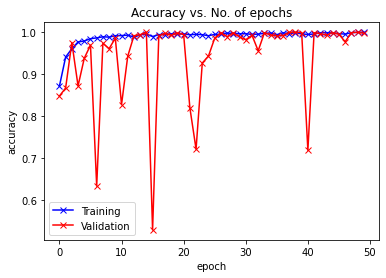

In [50]:
plot_accuracies(history)

# Graph of Training and Validation Loss

In [51]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

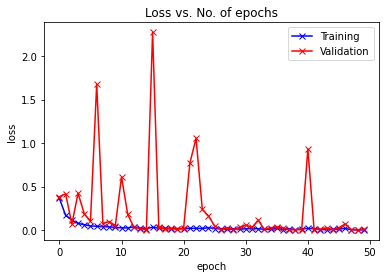

In [52]:
plot_losses(history)

# Testing with individual images

In [65]:
test_dataset = ImageFolder(data_dir+'/test', transform=tt.Compose
                      ([tt.ToTensor(), 
                        tt.Grayscale(num_output_channels=1), 
                        tt.Resize((100,100)), 
                        tt.Normalize(mean=(0.5), std=(0.5))
                       ]
                      ))

In [66]:
test_dataset.classes

['COVID19', 'NORMAL', 'VIRALPNUEMONIA']

Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [67]:
test_dataset.classes[0]

'COVID19'

In [68]:
len(test_dataset)

375

# Total count of each class in test dataset

In [ ]:
import collections

arr=np.array(test_dataset.targets)

def CountFrequency(arr):
    return collections.Counter(arr)  

freq = CountFrequency(arr)


for (key, value) in freq.items():
        print (test_dataset.classes[key],":",key,  " -> ", value)


In [69]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]
   

Label: COVID19 , Predicted: COVID19


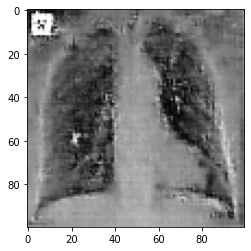

In [70]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: NORMAL , Predicted: NORMAL


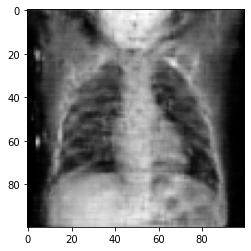

In [71]:
img, label = test_dataset[150]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: NORMAL , Predicted: NORMAL


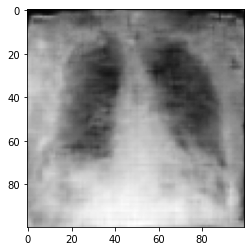

In [72]:
img, label = test_dataset[190]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: NORMAL , Predicted: NORMAL


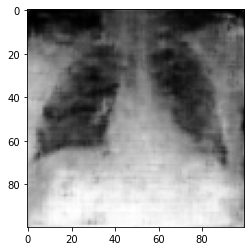

In [73]:
img, label = test_dataset[210]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: VIRALPNUEMONIA , Predicted: VIRALPNUEMONIA


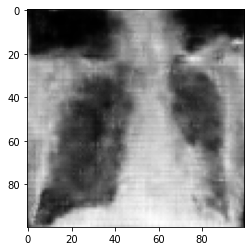

In [74]:
img, label = test_dataset[300]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

# Testing with batch of images

In [75]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)

In [76]:
result = evaluate_test(model, test_loader)
print(result)

{'test_loss': 0.10121753066778183, 'test_acc': 0.9800000190734863}


# Build a function to get predictions for all test samples

In [95]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    all_test_labels = torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch
        
        all_test_labels = torch.cat(
            (all_test_labels, labels)
            ,dim=0
        )

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        
    _, all_test_preds = torch.max(all_preds, dim=1)
        
        
    return all_test_preds, all_test_labels, all_preds



In [78]:
def get_num_correct(test_preds,labels):
  return torch.tensor(torch.sum(test_preds == labels).item())

In [96]:
with torch.no_grad():
    all_test_preds,all_test_labels, all_preds = get_all_preds(model, test_loader)
print("All Test Predictions:",all_test_preds)
print("All actual test labels:",all_test_labels)

All Test Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0,
        0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2

In [ ]:
all_test_preds.shape

In [ ]:
all_test_labels.shape

In [ ]:
all_test_preds.type(torch.int32)

In [ ]:
all_test_labels.type(torch.int32)

In [ ]:
all_test_preds == all_test_labels

In [ ]:
preds_correct = get_num_correct(all_test_preds, all_test_labels)
print('Total correct no of test predictions:', (preds_correct).item())
print('Test Accuracy:', (preds_correct / len(test_dataset)).item() * 100)

# Plotting The Confusion Matrix

In [80]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [81]:
stacked = torch.stack(
(
    all_test_labels.type(torch.int32),all_test_preds.type(torch.int32)
),dim=1

)

In [82]:
stacked

tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        

In [83]:
stacked[0].tolist()

[0, 0]

In [84]:
cmt = torch.zeros(3,3,dtype=torch.int32)
cmt

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.int32)

In [85]:
for p in stacked:
    true_label,predicted_label = p.tolist()
    cmt[true_label,predicted_label] = cmt[true_label,predicted_label] + 1
cmt    

tensor([[ 51,   0,   8],
        [  0, 164,   0],
        [  0,   0, 152]], dtype=torch.int32)

In [86]:
cm = confusion_matrix(all_test_labels.cpu().numpy(),all_test_preds.cpu().numpy())
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[ 51,   0,   8],
       [  0, 164,   0],
       [  0,   0, 152]], dtype=int64)

Confusion matrix, without normalization
[[ 51   0   8]
 [  0 164   0]
 [  0   0 152]]


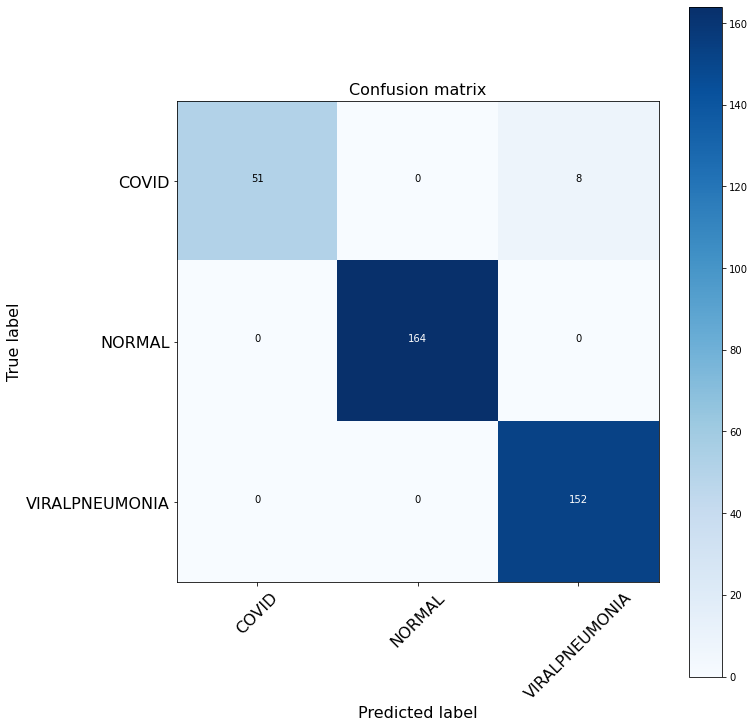

In [87]:
names = ('COVID', 'NORMAL','VIRALPNEUMONIA')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,names)
plt.xticks(range(3), names, fontsize=16)
plt.yticks(range(3), names, fontsize=16)
plt.show()

# Classification Report

In [88]:
from sklearn.metrics import classification_report
target_names = ['COVID-19', 'NORMAL', 'VIRALPNEUMONIA']
{'COVID': 0, 'NORMAL': 1, 'VIRALPNEUMONIA': 2}
print(classification_report(all_test_labels.cpu(), all_test_preds.cpu(), target_names=target_names))

                precision    recall  f1-score   support

      COVID-19       1.00      0.86      0.93        59
        NORMAL       1.00      1.00      1.00       164
VIRALPNEUMONIA       0.95      1.00      0.97       152

      accuracy                           0.98       375
     macro avg       0.98      0.95      0.97       375
  weighted avg       0.98      0.98      0.98       375



# ROC Curve

In [90]:
# Binarize the output
from sklearn.preprocessing import label_binarize
y_true = label_binarize(all_test_labels.cpu(), classes=[0, 1, 2])
n_classes = y_true.shape[1]

In [91]:
y_true

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [97]:
all_preds.cpu().numpy().shape

(375, 3)

In [100]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_preds.cpu()[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_preds.cpu().ravel(),pos_label=1)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

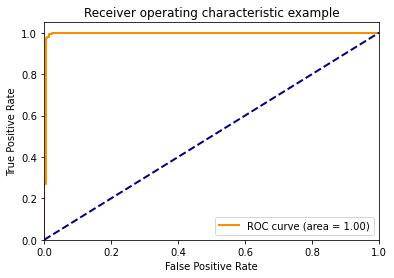

In [101]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [102]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [103]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

In [104]:
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

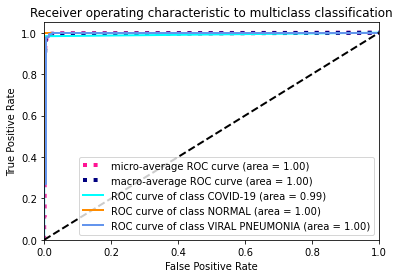

In [107]:
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
labels = cycle(["COVID-19", "NORMAL","VIRAL PNEUMONIA"])
for i, color , label in zip(range(n_classes), colors, labels):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(label, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic to multiclass classification")
plt.legend(loc="lower right")
plt.show()